In [187]:
from utils import balance_sample, univariate_classifier

import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as pgo
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)


from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
)
from sklearn.ensemble import ExtraTreesClassifier

from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [188]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 2  # width in inches
fig_height = 8  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1.5,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
        'figure.figsize': fig_size
    },
)

sns.set_palette(sns.color_palette(nt_colors))

# Load Data

In [192]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [193]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_)
    
# df.to_csv('Data/all_markers.csv')

In [217]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'msf', 'sef90', 'sef95', 'b', 'b_n', 'g',
       'g_n', 't', 't_n', 'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']
erps =['CNV', 'P1', 'P3a', 'P3b']


df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df_markers
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial <= 4')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             ).drop('se', axis =1)

df_markers.to_csv('Data/all_markers.csv')

# By Subject Univariate analyses 

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [6]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .groupby(['mind2', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_mind.drop(markers, axis=1).columns})

df_mind = (df_mind
    .groupby(['mind2', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
)

df_mind.columns = df_mind.columns.map("_".join)
df_mind  = df_mind.rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_first':'mind2'})
df_mind = balance_sample(df_mind, 'participant', 'mind2', levels = 2).drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also

AUC wSMI_1_mean = 0.44444444444444453 WilcoxonResult(statistic=18.0, pvalue=0.10986328125)
AUC wSMI_1_std = 0.4375 WilcoxonResult(statistic=28.0, pvalue=0.423828125)
AUC wSMI_2_mean = 0.4583333333333333 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC wSMI_2_std = 0.4513888888888889 WilcoxonResult(statistic=31.0, pvalue=0.5693359375)
AUC wSMI_4_mean = 0.3888888888888889 WilcoxonResult(statistic=27.0, pvalue=0.38037109375)
AUC wSMI_4_std = 0.46527777777777773 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC wSMI_8_mean = 0.45833333333333337 WilcoxonResult(statistic=29.0, pvalue=0.4697265625)
AUC wSMI_8_std = 0.3680555555555556 WilcoxonResult(statistic=23.0, pvalue=0.2333984375)
AUC p_e_1_mean = 0.5138888888888888 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
AUC p_e_1_std = 0.4305555555555556 WilcoxonResult(statistic=23.0, pvalue=0.2333984375)
AUC p_e_2_mean = 0.5277777777777778 WilcoxonResult(statistic=29.0, pvalue=0.4697265625)
AUC p_e_2_std = 0.48611111111111116 

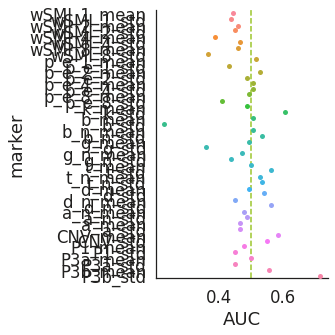

In [7]:
AUC = []
significants = []

for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append(i)

print(f'List of significant markers: {significants}')

subject_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = subject_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_1_mean = 0.6458333333333333
AUC wSMI_1_std = 0.7361111111111112
AUC wSMI_2_mean = 0.6944444444444444
AUC wSMI_2_std = 0.6944444444444444
AUC wSMI_4_mean = 0.24305555555555558
AUC wSMI_4_std = 0.5972222222222222
AUC wSMI_8_mean = 0.6597222222222222
AUC wSMI_8_std = 0.763888888888889
AUC p_e_1_mean = 0.5972222222222222
AUC p_e_1_std = 0.6180555555555556
AUC p_e_2_mean = 0.5902777777777778
AUC p_e_2_std = 0.6180555555555556
AUC p_e_4_mean = 0.6041666666666667
AUC p_e_4_std = 0.7083333333333334
AUC p_e_8_mean = 0.611111111111111
AUC p_e_8_std = 0.6666666666666667
AUC k_mean = 0.5833333333333334
AUC k_std = 0.7534722222222222
AUC b_mean = 0.5763888888888888
AUC b_std = 0.20833333333333334
AUC b_n_mean = 0.7743055555555556
AUC b_n_std = 0.20833333333333334
AUC g_mean = 0.6041666666666667
AUC g_std = 0.6805555555555556
AUC g_n_mean = 0.5902777777777778
AUC g_n_std = 0.6388888888888888
AUC t_mean = 0.5763888888888888
AUC t_std = 0.7291666666666666
AUC t_n_mean = 0.6736111111111112
AUC

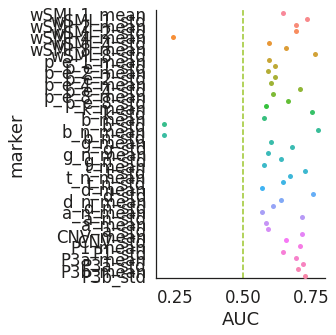

In [27]:
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [10]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['mind', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_mw.drop(markers, axis=1).columns})

df_mw = (df_mw
    .groupby(['mind', 'participant'], as_index = False).agg(agg_dict)
)
df_mw = balance_sample(df_mw, 'participant', 'mind', levels = 2).drop(['participant', 'probe','segment'], axis = 1) 


AUC wSMI_1 = 0.5234375 WilcoxonResult(statistic=68.0, pvalue=1.0)
AUC wSMI_2 = 0.390625 WilcoxonResult(statistic=45.0, pvalue=0.252227783203125)
AUC wSMI_4 = 0.515625 WilcoxonResult(statistic=50.0, pvalue=0.375457763671875)
AUC wSMI_8 = 0.53515625 WilcoxonResult(statistic=64.0, pvalue=0.860260009765625)
AUC p_e_1 = 0.52734375 WilcoxonResult(statistic=56.0, pvalue=0.5618896484375)
AUC p_e_2 = 0.5390625 WilcoxonResult(statistic=40.0, pvalue=0.1590576171875)
AUC p_e_4 = 0.5 WilcoxonResult(statistic=68.0, pvalue=1.0)
AUC p_e_8 = 0.484375 WilcoxonResult(statistic=44.0, pvalue=0.231201171875)
AUC k = 0.5390625 WilcoxonResult(statistic=53.0, pvalue=0.4637451171875)
AUC b = 0.5078125 WilcoxonResult(statistic=61.0, pvalue=0.743560791015625)
AUC b_n = 0.515625 WilcoxonResult(statistic=59.0, pvalue=0.668548583984375)
AUC g = 0.515625 WilcoxonResult(statistic=54.0, pvalue=0.49542236328125)
AUC g_n = 0.55078125 WilcoxonResult(statistic=47.0, pvalue=0.2978515625)
AUC t = 0.48046875 WilcoxonResult(st

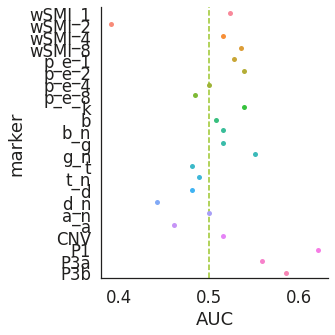

In [11]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append(i)
subject_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants}')


sns.catplot(x = 'AUC', y = 'marker', data = subject_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_1 = 0.6171875
AUC wSMI_2 = 0.21875
AUC wSMI_4 = 0.697265625
AUC wSMI_8 = 0.7265625
AUC p_e_1 = 0.544921875
AUC p_e_2 = 0.56640625
AUC p_e_4 = 0.59375
AUC p_e_8 = 0.68359375
AUC k = 0.5625
AUC b = 0.56640625
AUC b_n = 0.60546875
AUC g = 0.5859375
AUC g_n = 0.5625
AUC t = 0.59375
AUC t_n = 0.60546875
AUC d = 0.60546875
AUC d_n = 0.58984375
AUC a_n = 0.59765625
AUC a = 0.62109375
AUC CNV = 0.40625
AUC P1 = 0.640625
AUC P3a = 0.61328125
AUC P3b = 0.60546875
Index(['dMW', 'sMW'], dtype='object')


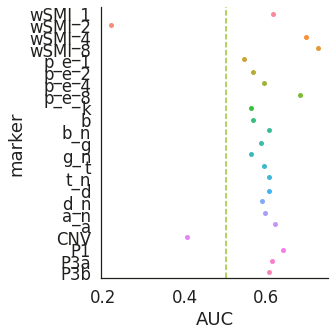

In [12]:
AUC = []
for i in df_mw.drop('mind', axis = 1).columns:
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Segment Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [220]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind  = (df_mind
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_':'mind2'})
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )

In [221]:
AUC = []
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = ot, y = mw).pvalue 
        
segment_mind_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
segment_mind_roc = (segment_mind_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )
segment_mind_roc.to_csv('Data/univariate_roc_mind_segment.csv')

AUC wSMI_1_mean = 0.5096004151530877 MannwhitneyuResult(statistic=3780.0, pvalue=0.4137215987664847)
AUC wSMI_1_std = 0.5451478982874935 MannwhitneyuResult(statistic=3506.0, pvalue=0.15136543839826566)
AUC wSMI_2_mean = 0.5408666320705761 MannwhitneyuResult(statistic=3539.0, pvalue=0.17548089290801433)
AUC wSMI_2_std = 0.5428126621691749 MannwhitneyuResult(statistic=3524.0, pvalue=0.1642322353916693)
AUC wSMI_4_mean = 0.5381421899325377 MannwhitneyuResult(statistic=3560.0, pvalue=0.19202868252179917)
AUC wSMI_4_std = 0.5797872340425533 MannwhitneyuResult(statistic=3239.0, pvalue=0.03419355711886559)
AUC wSMI_8_mean = 0.5131032693305657 MannwhitneyuResult(statistic=3753.0, pvalue=0.38282986322026213)
AUC wSMI_8_std = 0.48430202387130256 MannwhitneyuResult(statistic=3733.0, pvalue=0.3604067720617936)
AUC p_e_1_mean = 0.516476388168137 MannwhitneyuResult(statistic=3727.0, pvalue=0.3537684464398442)
AUC p_e_1_std = 0.5662947586922678 MannwhitneyuResult(statistic=3343.0, pvalue=0.0650115899

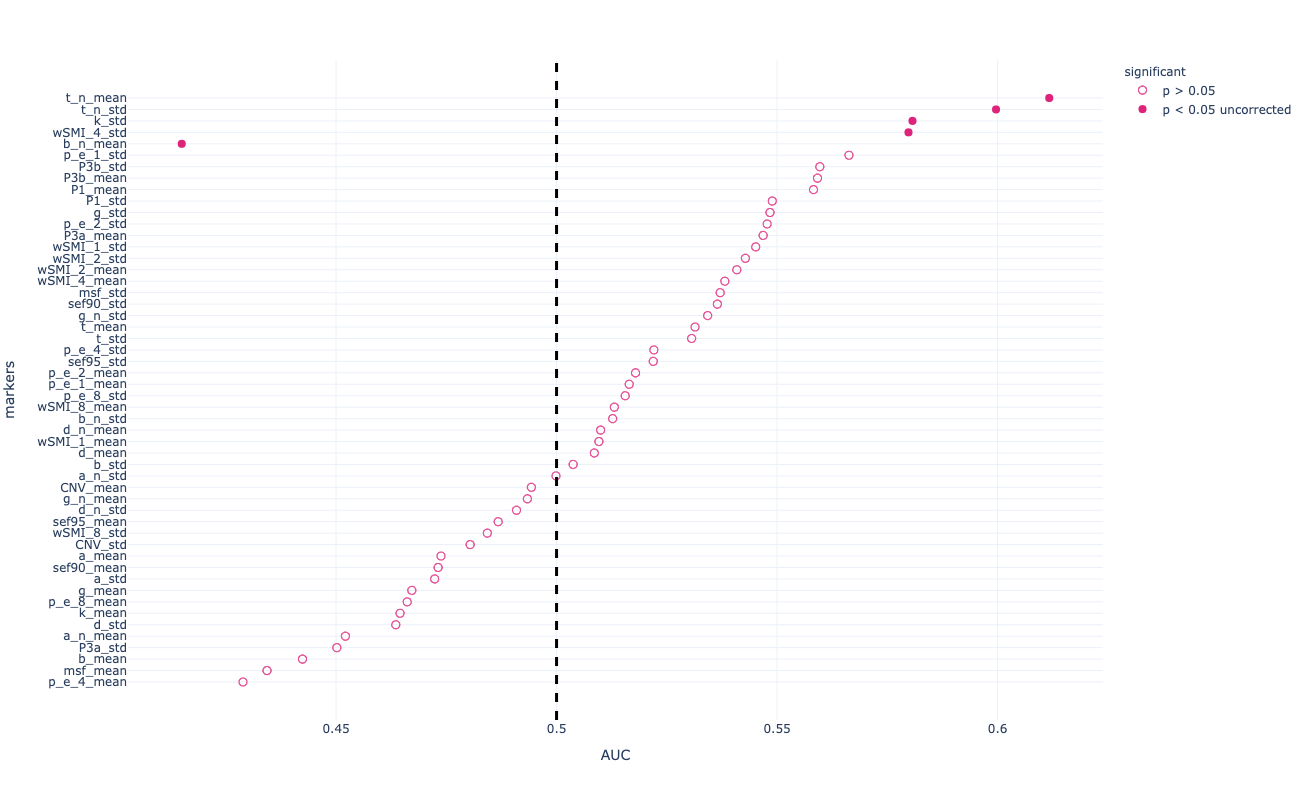

In [223]:
segment_mind_roc = pd.read_csv('Data/univariate_roc_mind_segment.csv')
fig = px.scatter(segment_mind_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [pink, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

AUC wSMI_1 = 0.5093437665782494
p_value = 0.35664335664335667
AUC wSMI_2 = 0.4934995579133511
p_value = 0.6083916083916084
AUC wSMI_4 = 0.47240247568523436
p_value = 0.8521478521478522
AUC wSMI_8 = 0.5152465075154731
p_value = 0.3026973026973027
AUC p_e_1 = 0.5092412024756852
p_value = 0.3516483516483517
AUC p_e_2 = 0.5423904509283819
p_value = 0.06493506493506493
AUC p_e_4 = 0.5287236074270558
p_value = 0.15084915084915085
AUC p_e_8 = 0.47355667550839964
p_value = 0.8341658341658341
AUC k = 0.48588691423519004
p_value = 0.6803196803196803
AUC msf = 0.548274801061008
p_value = 0.03696303696303696
AUC sef90 = 0.5075163572060124
p_value = 0.3676323676323676
AUC sef95 = 0.4903111405835544
p_value = 0.6243756243756243
AUC b = 0.5334344827586206
p_value = 0.13286713286713286
AUC b_n = 0.5744610079575597
p_value = 0.003996003996003996
AUC g = 0.43675968169761276
p_value = 0.993006993006993
AUC g_n = 0.48129743589743584
p_value = 0.7512487512487512
AUC t = 0.5074229885057472
p_value = 0.37762

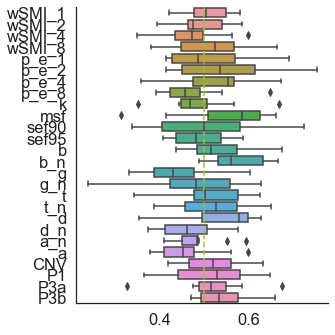

In [241]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mind, label = 'mind2', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mind = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']))
           )
svc_mind.to_csv('Data/univariate_svc_mind_segment.csv')

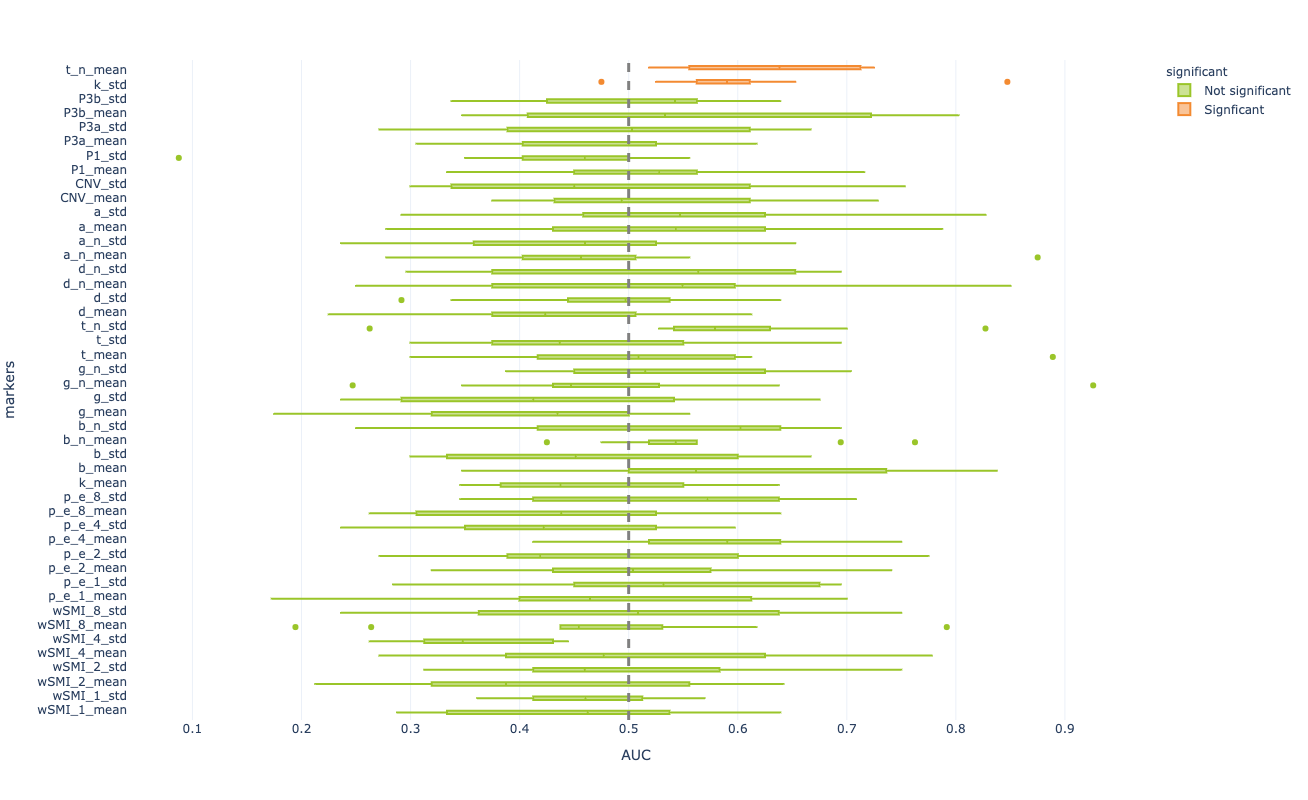

In [42]:
svc_mind = pd.read_csv('Data/univariate_svc_mind_segment.csv')

fig = px.box(svc_mind, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mind_segment.plotly')

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [242]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_mw.columns = df_mw.columns.map("_".join)

df_mw  = (df_mw
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'probe', 'segment'], axis = 1) 
           )

In [225]:
AUC = []
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = smw, y =dmw).pvalue 
        
segment_mw_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
segment_mw_roc = (segment_mw_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                   )
           )

segment_mw_roc.to_csv('Data/univariate_roc_mw_segment.csv')

AUC wSMI_1_mean = 0.523944055944056 MannwhitneyuResult(statistic=34038.0, pvalue=0.1693306604514288)
AUC wSMI_1_std = 0.5100699300699301 MannwhitneyuResult(statistic=35030.0, pvalue=0.34375506602058203)
AUC wSMI_2_mean = 0.4840559440559441 MannwhitneyuResult(statistic=34610.0, pvalue=0.2620503088572066)
AUC wSMI_2_std = 0.49558041958041954 MannwhitneyuResult(statistic=35434.0, pvalue=0.42999763071153285)
AUC wSMI_4_mean = 0.5073286713286713 MannwhitneyuResult(statistic=35226.0, pvalue=0.3848900507447925)
AUC wSMI_4_std = 0.473020979020979 MannwhitneyuResult(statistic=33821.0, pvalue=0.14048844218995282)
AUC wSMI_8_mean = 0.4704755244755245 MannwhitneyuResult(statistic=33639.0, pvalue=0.11902506624172043)
AUC wSMI_8_std = 0.49472727272727274 MannwhitneyuResult(statistic=35373.0, pvalue=0.41664565905438294)
AUC p_e_1_mean = 0.5583216783216783 MannwhitneyuResult(statistic=31580.0, pvalue=0.009877788763454468)
AUC p_e_1_std = 0.4821678321678321 MannwhitneyuResult(statistic=34475.0, pvalue=

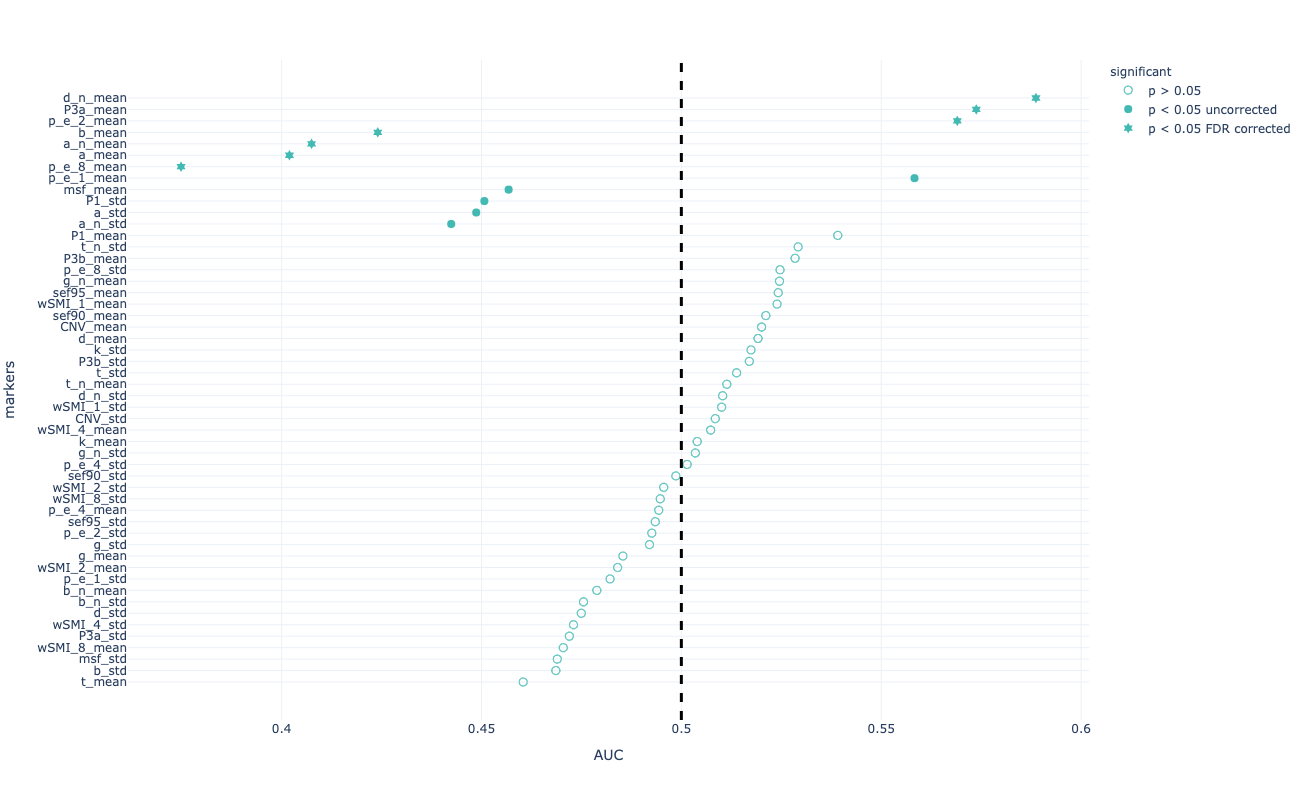

In [226]:
segment_mw_roc = pd.read_csv('Data/univariate_roc_mw_segment.csv')
fig = px.scatter(segment_mw_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [lblue, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_traces(marker=dict(size = 8))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

In [243]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mw = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']))
           )
svc_mw.to_csv('Data/univariate_svc_mw.csv')

AUC wSMI_1_mean = 0.5220591133004927
p_value = 0.22877122877122877
AUC wSMI_1_std = 0.5199113300492612
p_value = 0.24675324675324675
AUC wSMI_2_mean = 0.5065714285714286
p_value = 0.41058941058941056
AUC wSMI_2_std = 0.459807881773399
p_value = 0.9070929070929071
AUC wSMI_4_mean = 0.49175862068965515
p_value = 0.6133866133866134
AUC wSMI_4_std = 0.5197684729064039
p_value = 0.24275724275724275
AUC wSMI_8_mean = 0.48403940886699515
p_value = 0.7172827172827173
AUC wSMI_8_std = 0.49996551724137933
p_value = 0.4885114885114885
AUC p_e_1_mean = 0.5563645320197044
p_value = 0.016983016983016984
AUC p_e_1_std = 0.49500985221674887
p_value = 0.5444555444555444
AUC p_e_2_mean = 0.5656305418719212
p_value = 0.00999000999000999
AUC p_e_2_std = 0.48058128078817736
p_value = 0.7342657342657343
AUC p_e_4_mean = 0.49524137931034484
p_value = 0.5704295704295704
AUC p_e_4_std = 0.5191871921182266
p_value = 0.2647352647352647
AUC p_e_8_mean = 0.6303152709359605
p_value = 0.000999000999000999
AUC p_e_8_

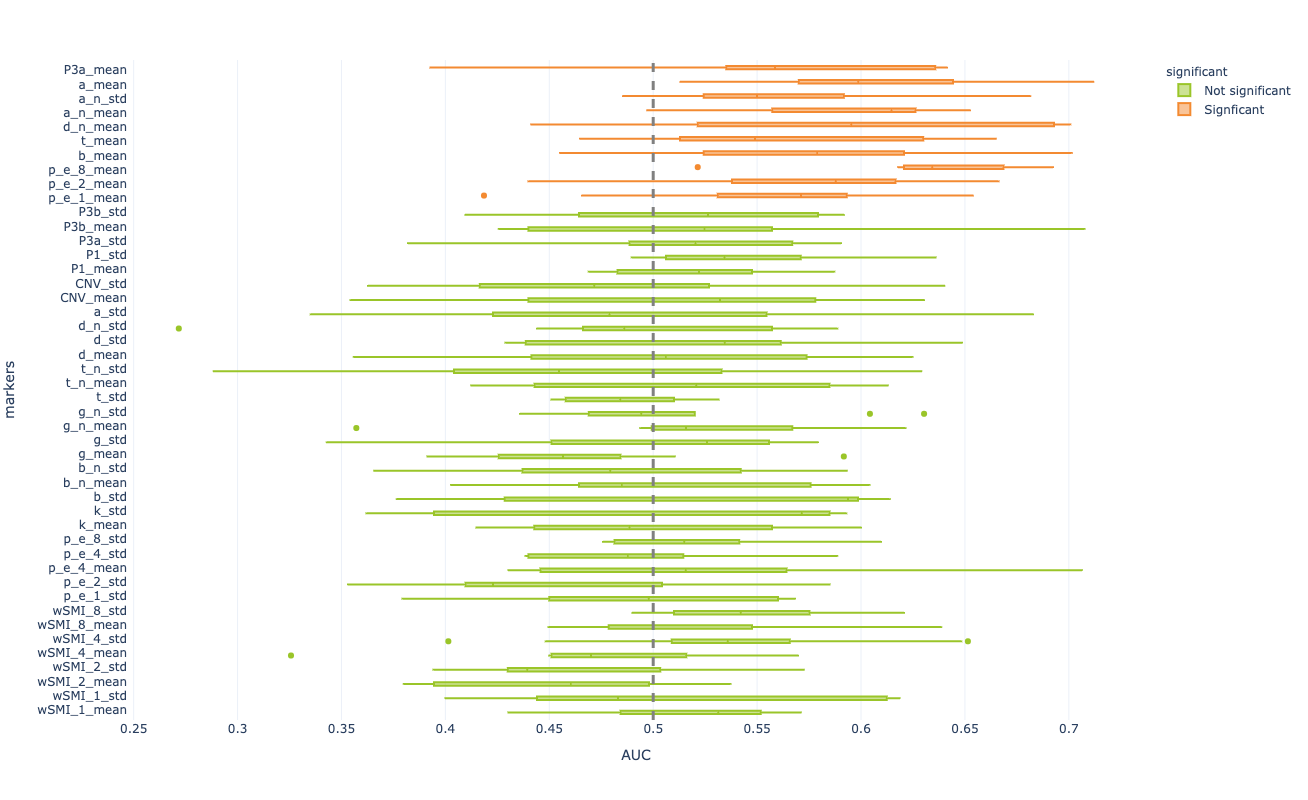

In [41]:
pd.read_csv('Data/univariate_svc_mw.csv')

fig = px.box(svc_mw, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)


fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mw_segment.plotly')


# By Trial Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [231]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

In [232]:
AUC = []
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = ot, y = mw).pvalue 
        
trial_mind_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
trial_mind_roc = (trial_mind_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )
trial_mind_roc.to_csv('Data/univariate_roc_mind_trial.csv')

AUC wSMI_1 = 0.4927448450214626 MannwhitneyuResult(statistic=37422.0, pvalue=0.3843806894864651)
AUC wSMI_2 = 0.5181444710715509 MannwhitneyuResult(statistic=36595.0, pvalue=0.23096997767776806)
AUC wSMI_4 = 0.5206857504016011 MannwhitneyuResult(statistic=36402.0, pvalue=0.20081093379294496)
AUC wSMI_8 = 0.5112448318542122 MannwhitneyuResult(statistic=37119.0, pvalue=0.32426218739075374)
AUC p_e_1 = 0.5182103073236246 MannwhitneyuResult(statistic=36590.0, pvalue=0.23015804797957068)
AUC p_e_2 = 0.5225423327100835 MannwhitneyuResult(statistic=36261.0, pvalue=0.18035068409966132)
AUC p_e_4 = 0.4397729966028494 MannwhitneyuResult(statistic=33399.0, pvalue=0.007293260345101261)
AUC p_e_8 = 0.4814473441655913 MannwhitneyuResult(statistic=36564.0, pvalue=0.22596185055481743)
AUC k = 0.47977510336291573 MannwhitneyuResult(statistic=36437.0, pvalue=0.2060964294458162)
AUC msf = 0.45930002896795097 MannwhitneyuResult(statistic=34882.0, pvalue=0.04942165309067732)
AUC sef90 = 0.48181602717720484

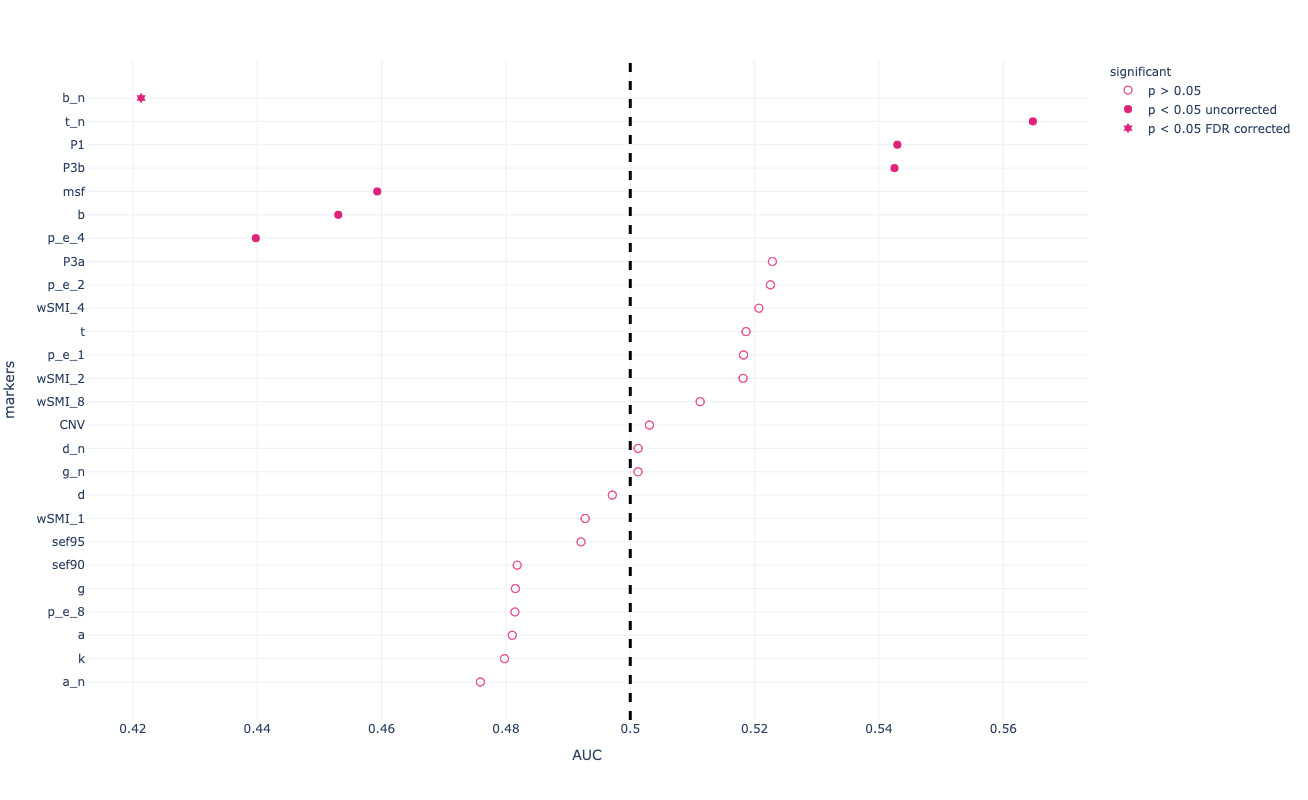

In [234]:
trial_mind_roc = pd.read_csv('Data/univariate_roc_mind_trial.csv')
fig = px.scatter(trial_mind_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [pink, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

In [48]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mind, label = 'mind2', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mind_trial = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
svc_mind_trial.to_csv('Data/univariate_svc_mind_trial.csv')

AUC wSMI_1 = 0.4904762157382847
p_value = 0.6313686313686314
AUC wSMI_2 = 0.5092984969053934
p_value = 0.3516483516483517
AUC wSMI_4 = 0.4992732095490716
p_value = 0.5194805194805194
AUC wSMI_8 = 0.4958969053934571
p_value = 0.5694305694305695
AUC p_e_1 = 0.5071076923076923
p_value = 0.35764235764235763
AUC p_e_2 = 0.5026443854995579
p_value = 0.46853146853146854
AUC p_e_4 = 0.540705216622458
p_value = 0.07892107892107893
AUC p_e_8 = 0.4901211317418214
p_value = 0.6093906093906094
AUC k = 0.5052061892130858
p_value = 0.4275724275724276
AUC b = 0.55764350132626
p_value = 0.016983016983016984
AUC b_n = 0.5590843501326261
p_value = 0.013986013986013986
AUC g = 0.4571798408488063
p_value = 0.945054945054945
AUC g_n = 0.46338638373121127
p_value = 0.8831168831168831
AUC t = 0.4609236074270557
p_value = 0.936063936063936
AUC t_n = 0.48273492484526975
p_value = 0.6973026973026973
AUC d = 0.5066611847922193
p_value = 0.3866133866133866
AUC d_n = 0.5275541998231653
p_value = 0.17882117882117882

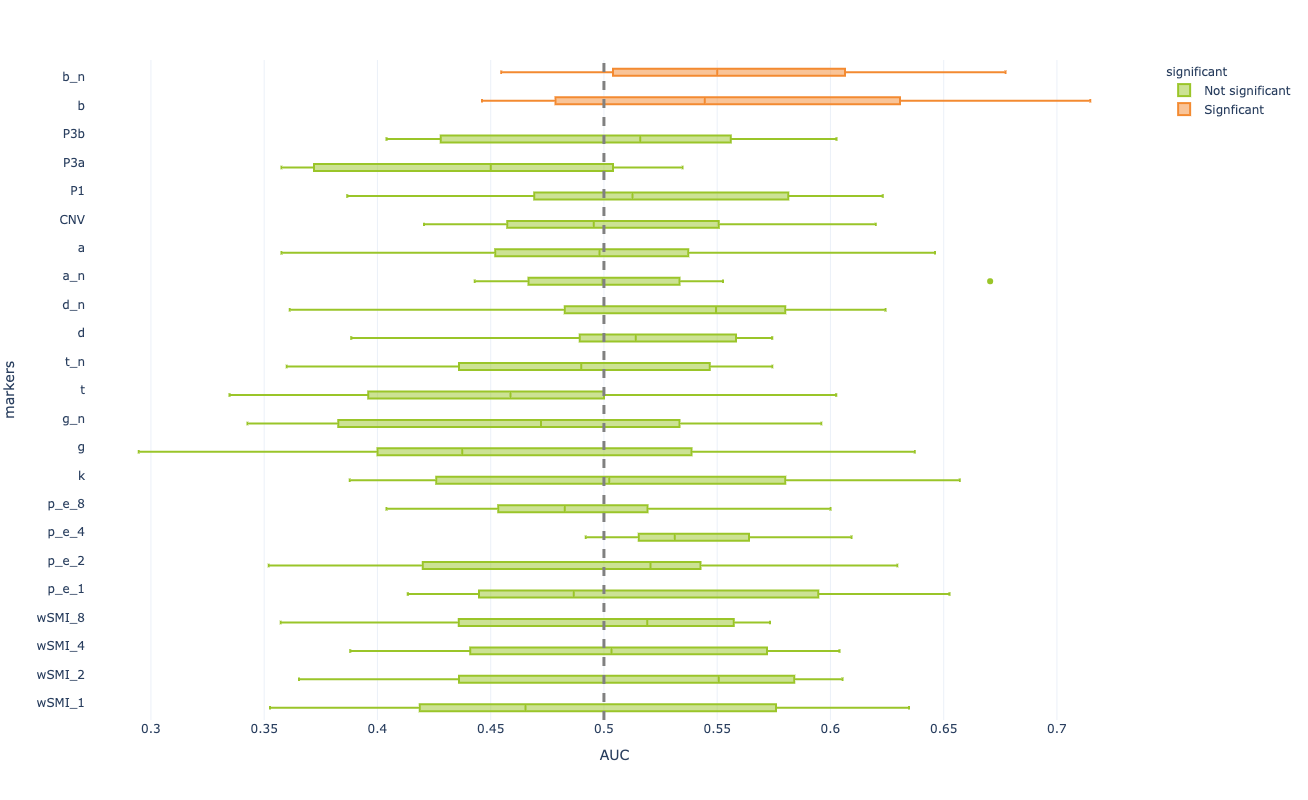

In [49]:
svc_mind_trial = pd.read_csv('Data/univariate_svc_mind_trial.csv')

fig = px.box(svc_mind_trial, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mind_trial.plotly')

In [ ]:
n_estimators = 2000
AUC = pd.DataFrame()
for i in  df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [236]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe', 'segment'], axis = 1)
)

In [237]:
AUC = []
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = smw, y =dmw).pvalue 
        
trial_mw_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
trial_mw_roc = (trial_mw_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                   )
           )

trial_mw_roc.to_csv('Data/univariate_roc_mw_trial.csv')

AUC wSMI_1 = 0.5192941762054488 MannwhitneyuResult(statistic=295524.0, pvalue=0.09320602799498495)
AUC wSMI_2 = 0.4864233999326579 MannwhitneyuResult(statistic=299039.0, pvalue=0.17626037636775255)
AUC wSMI_4 = 0.5125746009489712 MannwhitneyuResult(statistic=299655.0, pvalue=0.1945939523543157)
AUC wSMI_8 = 0.48200712135087703 MannwhitneyuResult(statistic=296324.0, pvalue=0.10894632373949803)
AUC p_e_1 = 0.5629104170496007 MannwhitneyuResult(statistic=268710.0, pvalue=8.227935107616532e-06)
AUC p_e_2 = 0.5657504989662817 MannwhitneyuResult(statistic=266964.0, pvalue=3.3541861453553647e-06)
AUC p_e_4 = 0.4971054262481477 MannwhitneyuResult(statistic=305606.0, pvalue=0.4214546701531839)
AUC p_e_8 = 0.40839597183341436 MannwhitneyuResult(statistic=251070.0, pvalue=1.7677670386055833e-10)
AUC k = 0.5073124789555785 MannwhitneyuResult(statistic=302890.0, pvalue=0.3082818405558336)
AUC msf = 0.46307324190633586 MannwhitneyuResult(statistic=284684.0, pvalue=0.0057226480919798164)
AUC sef90 = 

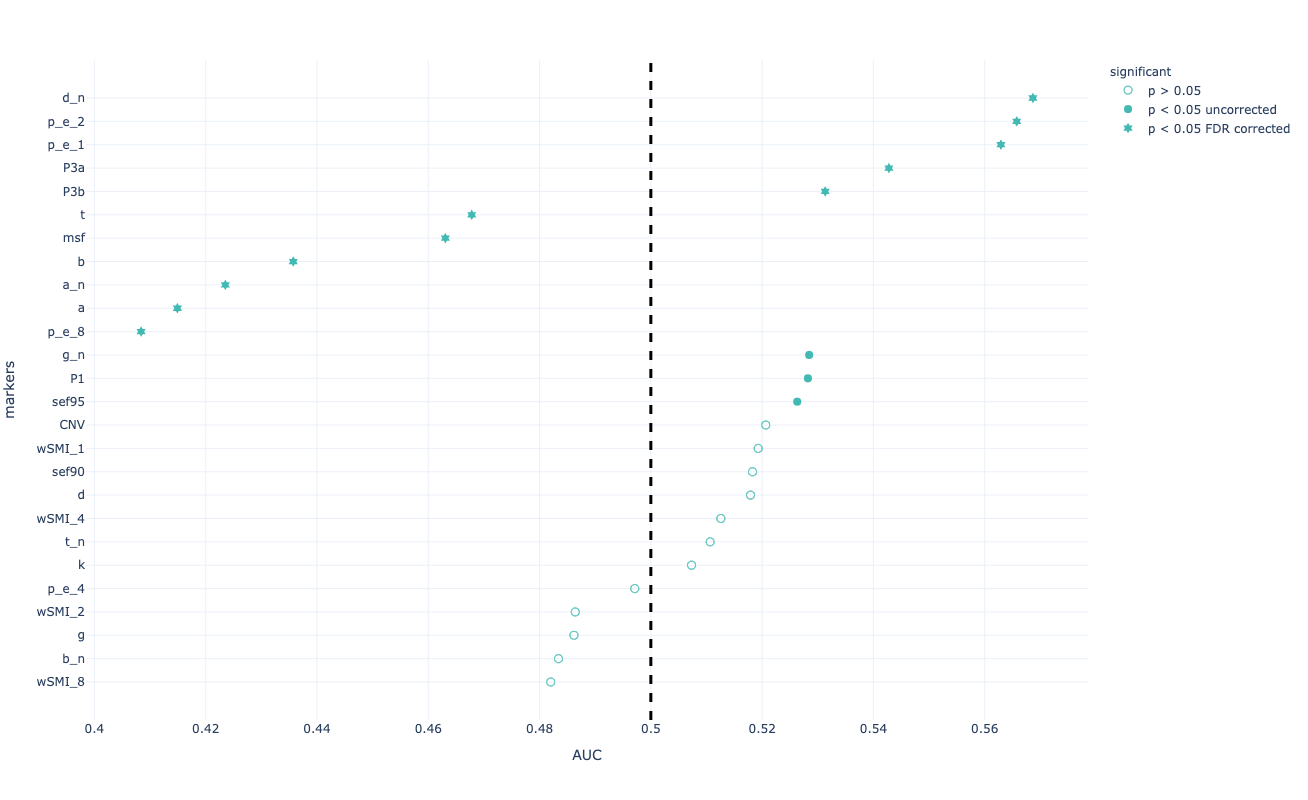

In [239]:
trial_mw_roc = pd.read_csv('Data/univariate_roc_mw_trial.csv')
fig = px.scatter(trial_mw_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [lblue, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_traces(marker=dict(size = 8))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

In [53]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mw_trial = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
svc_mw_trial.to_csv('Data/univariate_svc_mw_trial.csv')

AUC wSMI_1 = 0.5018059811855137
p_value = 0.46853146853146854
AUC wSMI_2 = 0.4859879601599989
p_value = 0.8411588411588412
AUC wSMI_4 = 0.497206063839827
p_value = 0.5744255744255744
AUC wSMI_8 = 0.48274134385335027
p_value = 0.8731268731268731
AUC p_e_1 = 0.5641385413847138
p_value = 0.000999000999000999
AUC p_e_2 = 0.5727134804310468
p_value = 0.000999000999000999


KeyboardInterrupt: 

In [ ]:
pd.read_csv('Data/univariate_svc_mw_trial.csv')

fig = px.box(svc_mw_trial, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)


fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mw_trial.plotly')


# Plots

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

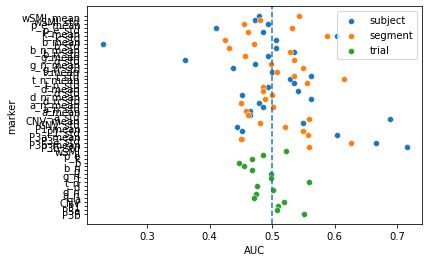

In [135]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mind_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

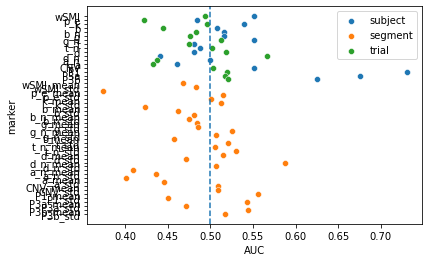

In [136]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mw_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## Comparison of significan markers for Mind and Mw

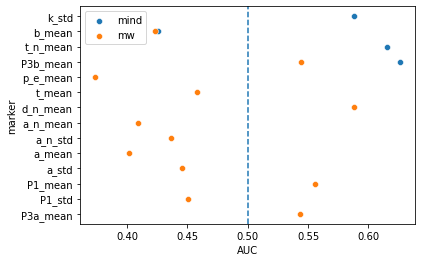

In [134]:
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mind )
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mw )
plt.legend(['mind','mw'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()